<a href="https://colab.research.google.com/github/koushik-ace/NLP/blob/main/NLP_Assignment%204.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'imdb-dataset-of-50k-movie-reviews' dataset.
Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews


In [4]:
import pandas as pd

df = pd.read_csv(path + "/IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
positive = df[df['sentiment']== 'positive'].copy()
negative = df[df['sentiment']=='negative'].copy()

In [6]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

positive['tokenized_review'] = positive['review'].apply(word_tokenize)
negative['tokenized_review'] = negative['review'].apply(word_tokenize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [7]:
positive['tokenized_review'] = positive['tokenized_review'].apply(lambda x: [word.lower() for word in x])
negative['tokenized_review'] = negative['tokenized_review'].apply(lambda x: [word.lower() for word in x])

In [8]:
import string

def remove_punctuation(tokens):
    cleaned_tokens = []
    for token in tokens:
        # Remove punctuation from each token
        clean_token = ''.join([char for char in token if char not in string.punctuation])
        # Add the token to the cleaned list only if it's not empty
        if clean_token:
            cleaned_tokens.append(clean_token)
    return cleaned_tokens

positive['tokenized_review'] = positive['tokenized_review'].apply(remove_punctuation)
negative['tokenized_review'] = negative['tokenized_review'].apply(remove_punctuation)

print("Punctuation removed from positive['tokenized_review'] and negative['tokenized_review'].")

Punctuation removed from positive['tokenized_review'] and negative['tokenized_review'].


In [9]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

print("NLTK stopwords corpus downloaded and imported.")

NLTK stopwords corpus downloaded and imported.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

positive['tokenized_review'] = positive['tokenized_review'].apply(remove_stopwords)
negative['tokenized_review'] = negative['tokenized_review'].apply(remove_stopwords)

print("Stopwords removed from positive['tokenized_review'] and negative['tokenized_review'].")

Stopwords removed from positive['tokenized_review'] and negative['tokenized_review'].


In [11]:
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def preprocess(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = [w for w in text.split() if w not in ENGLISH_STOP_WORDS]
    return " ".join(tokens)

df["clean_review"] = df["review"].apply(preprocess)

positive_corpus = df[df["sentiment"] == "positive"]["clean_review"]
negative_corpus = df[df["sentiment"] == "negative"]["clean_review"]

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_pos = TfidfVectorizer(max_features=5000)
tfidf_neg = TfidfVectorizer(max_features=5000)

pos_matrix = tfidf_pos.fit_transform(positive_corpus)
neg_matrix = tfidf_neg.fit_transform(negative_corpus)

import numpy as np

def top_tfidf_terms(matrix, vectorizer, n=15):
    scores = matrix.mean(axis=0).A1
    terms = vectorizer.get_feature_names_out()
    top_idx = np.argsort(scores)[::-1][:n]
    return pd.Series(scores[top_idx], index=terms[top_idx])

top_positive = top_tfidf_terms(pos_matrix, tfidf_pos)
top_negative = top_tfidf_terms(neg_matrix, tfidf_neg)

print("Top 15 Positive Terms:\n", top_positive)
print("\nTop 15 Negative Terms:\n", top_negative)

Top 15 Positive Terms:
 br        0.065161
movie     0.054523
film      0.050889
like      0.026465
good      0.025629
great     0.024513
just      0.023268
story     0.022263
really    0.020878
time      0.020294
love      0.018212
best      0.017227
people    0.017027
movies    0.016624
films     0.016199
dtype: float64

Top 15 Negative Terms:
 br        0.070069
movie     0.062632
film      0.047817
like      0.030814
just      0.030528
bad       0.027002
good      0.024779
really    0.022479
time      0.020796
dont      0.019866
story     0.019472
movies    0.018602
people    0.017806
acting    0.017566
make      0.017403
dtype: float64


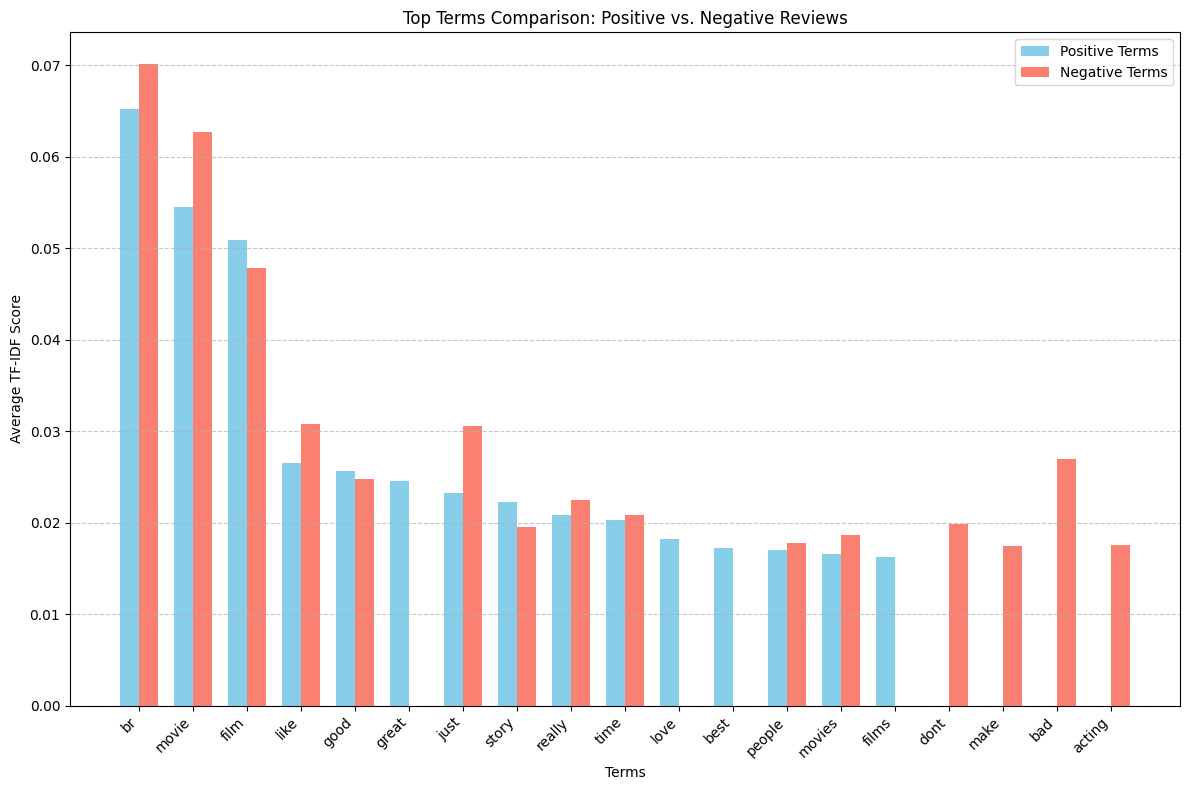

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Combine the top terms into a single DataFrame for plotting
comparison_df = pd.DataFrame({'Positive': top_positive, 'Negative': top_negative}).fillna(0)

# Get all unique terms from both series to ensure all terms are plotted
all_terms = list(set(top_positive.index) | set(top_negative.index))

# Filter the comparison_df to only include the terms from the original top lists
# This ensures we only plot the terms that were in the top 15 of either category
comparison_df = comparison_df.reindex(all_terms).fillna(0)

# Sort terms by positive TF-IDF score for consistent ordering
comparison_df = comparison_df.sort_values(by='Positive', ascending=False)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.35
index = np.arange(len(comparison_df))

bar1 = ax.bar(index - bar_width/2, comparison_df['Positive'], bar_width, label='Positive Terms', color='skyblue')
bar2 = ax.bar(index + bar_width/2, comparison_df['Negative'], bar_width, label='Negative Terms', color='salmon')

ax.set_xlabel('Terms')
ax.set_ylabel('Average TF-IDF Score')
ax.set_title('Top Terms Comparison: Positive vs. Negative Reviews')
ax.set_xticks(index)
ax.set_xticklabels(comparison_df.index, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()